# $\mathrm{n-C_3H_7ONO_2}$ (1-propyl nitrate)

In [35]:
using Pkg 
Pkg.activate("../")

  Activating project at `~/gitrepos/activepure/Photolysis.jl/mcm`


In [36]:
using Plots, MLPlotRecipes
using HDF5
using Tables, DataFrames, CSV
using MLJ, MLJGaussianProcesses
using StatsBase 
using KernelFunctions
using ParameterHandling

In [37]:
include("./utils.jl")

filter_outliers (generic function with 1 method)

# Loading Data

In [38]:
h5_path = "../../data/photolysis_data.h5" 
species = "n-C3H7ONO2" 
nice_name = "1-propyl nitrate"
λs, σs, T1s, T2s, source_idx, T_units, category, formula, λ_units, σ_units = get_raw_data(h5_path, species)

([220.0, 225.0, 230.0, 235.0, 240.0, 245.0, 250.0, 255.0, 260.0, 265.0  …  295.0, 300.0, 305.0, 310.0, 315.0, 320.0, 325.0, 330.0, 335.0, 340.0], [9.5e-19, 4.37e-19, 2.55e-19, 1.44e-19, 8.68e-20, 5.59e-20, 4.39e-20, 3.89e-20, 3.51e-20, 3.16e-20  …  9.64e-21, 6.43e-21, 4.11e-21, 2.36e-21, 1.36e-21, 6.85e-22, 3.19e-22, 1.39e-22, 6.34e-23, 2.86e-23], [294.0, 294.0, 298.0, 298.0, 298.0, 298.0, 298.0], [NaN, NaN, NaN, NaN, NaN, NaN, NaN], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  7, 7, 7, 7, 7, 7, 7, 7, 7, 7], "K", "Organics (N-compounds)", "n-C3H7ONO2", "nm", "cm^2")

In [39]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 


In [40]:
println(nrow(hr4000_df))
println(maximum(hr4000_df.λ))
println(minimum(hr4000_df.λ))

3648
1120.216
194.249


In [41]:
Δλ = 50 # nm for padding
df = data_to_df(λs, σs, T1s, T2s, source_idx; λ_lb=minimum(hr4000_df.λ)-Δλ, λ_ub=maximum(hr4000_df.λ)+Δλ)
println(nrow(df))
describe(df)

230


Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,λ,278.25,185.0,283.485,340.0,0,Float64
2,σ,8.24558e-19,2.86e-23,1.975e-20,1.83e-17,0,Float64
3,T,296.157,294.0,298.0,298.0,0,Float64
4,source_id,3.40435,1,3.0,7,0,Int64


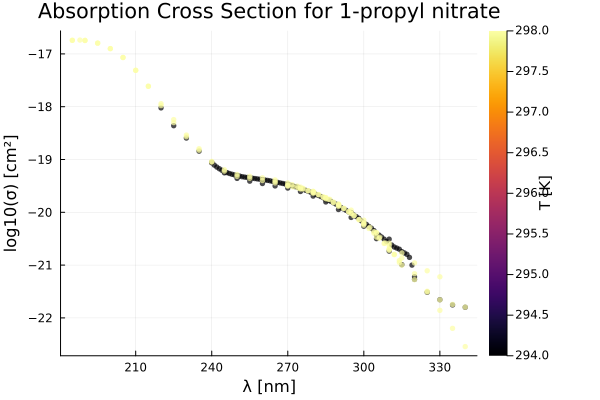

In [42]:
nskip = 1

p2 = scatter(
    df.λ[1:nskip:end],
    log10.(df.σ[1:nskip:end]),
    zcolor=df.T[1:nskip:end],
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Absorption Cross Section for $(nice_name)",
    label="",
)


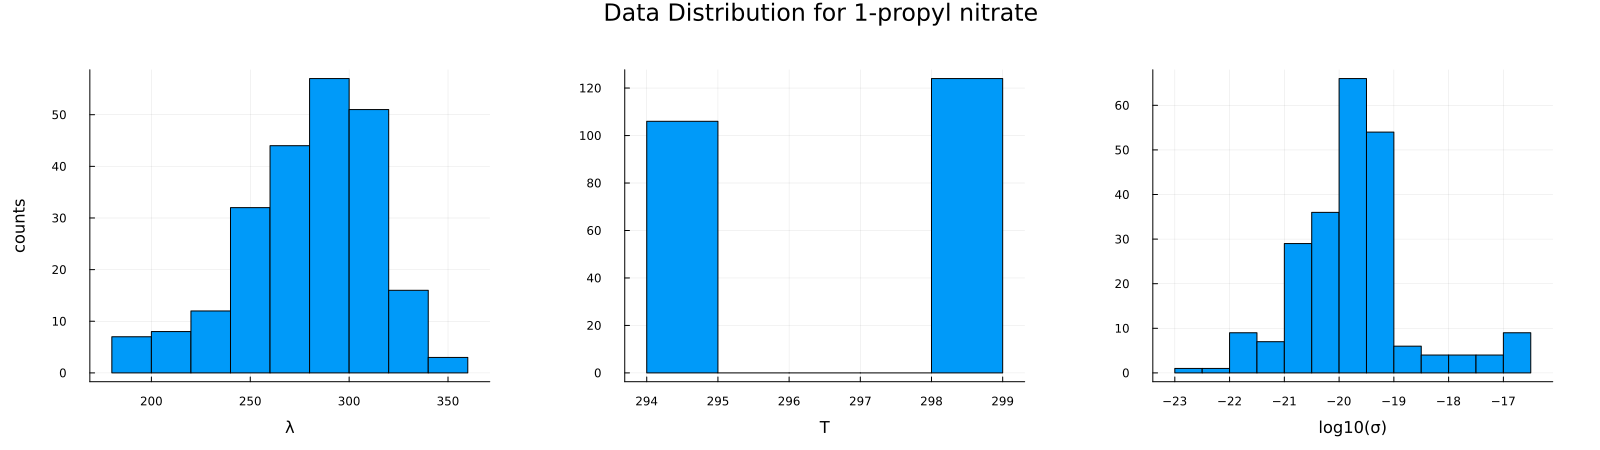

In [43]:
p1 = histogram(df.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(log10.(df.σ), xlabel="log10(σ)", label="", margin=10Plots.mm)
#p3 = histogram(df.σ, xlabel="σ", ylabel="counts")

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450), plot_title="Data Distribution for $(nice_name)")

In [44]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 

In [45]:
println(nrow(hr4000_df))
println(maximum(hr4000_df.λ))
println(minimum(hr4000_df.λ))

3648
1120.216
194.249


# Data Preprocessing

In [46]:
gdfs = groupby(df, :T)

res_dfs = []

for gdf ∈ gdfs
    gdf_by_λ = groupby(gdf, :λ)
    push!(res_dfs, combine(gdf_by_λ, [:σ, :T] .=> mean, renamecols = false))
end

df_unique = vcat(res_dfs...)

Row,λ,σ,T
,Float64,Float64,Float64
1,220.0,9.5e-19,294.0
2,225.0,4.37e-19,294.0
3,230.0,2.55e-19,294.0
4,235.0,1.44e-19,294.0
5,240.0,8.75e-20,294.0
6,241.0,7.84e-20,294.0
7,242.0,7.2e-20,294.0
8,243.0,6.68e-20,294.0
9,244.0,6.26e-20,294.0


In [47]:
df_unique = filter_outliers(df_unique, log10.(df_unique.σ))
println(nrow(df_unique))

# df_unique = df_unique[df_unique.T .!= 298.0, :]

148


In [48]:
λ_idxs = representative_rand_sample(df_unique.λ, 1000, 2000)
T_idxs = representative_rand_sample(df_unique.λ, 5, 500)
σ_idxs = representative_rand_sample(log10.(df_unique.σ), 500, 2000) 

idxs_res = shuffle(unique(vcat(λ_idxs, T_idxs,σ_idxs)))


df_sampled = df_unique[idxs_res, :]

println(size(df_sampled))

max_data_λ = maximum(df_sampled.λ)
min_data_λ = minimum(df_sampled.λ)

(148, 3)


220.0

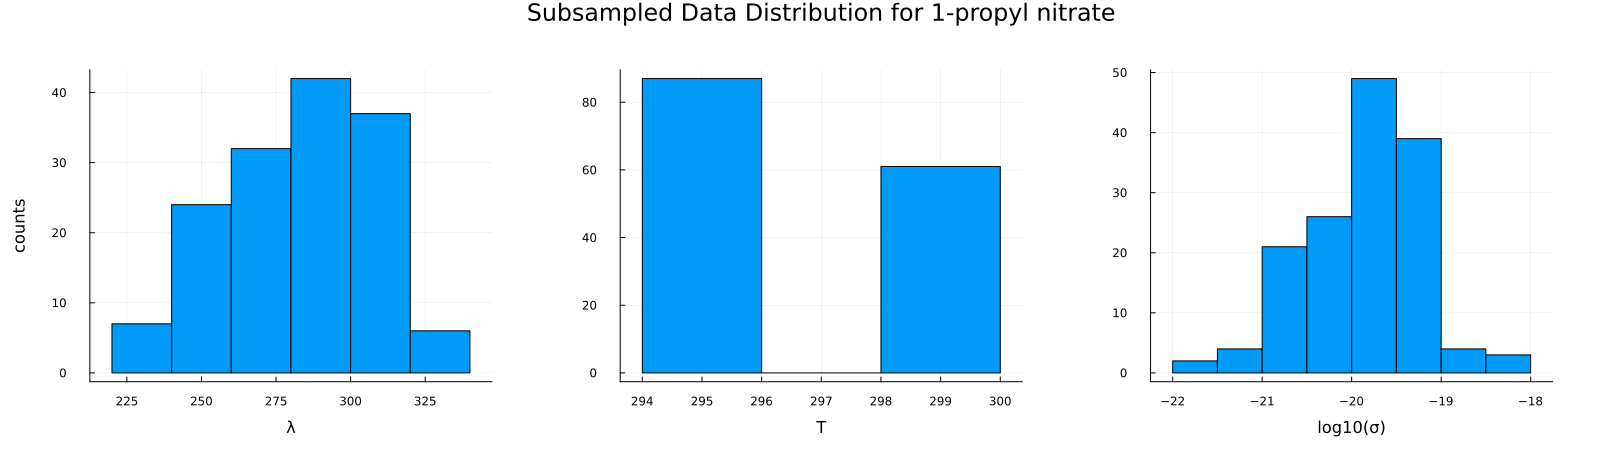

In [49]:
p1 = histogram(df_sampled.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df_sampled.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(log10.(df_sampled.σ), xlabel="log10(σ)", label="", margin=10Plots.mm)
#p3 = histogram(df.σ, xlabel="σ", ylabel="counts")

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450), plot_title="Subsampled Data Distribution for $(nice_name)")

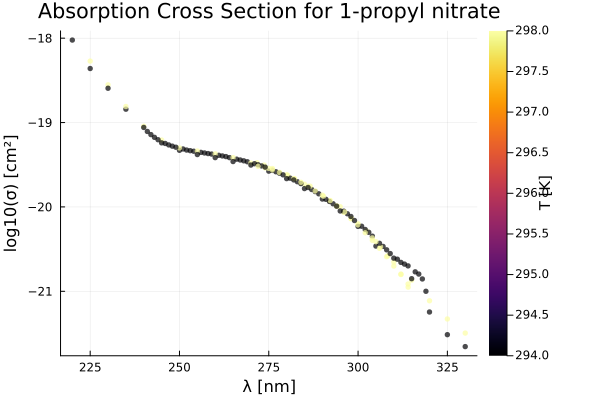

In [50]:
p = scatter(
    df_sampled.λ,
    log10.(df_sampled.σ),
    zcolor=df_sampled.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Absorption Cross Section for $(nice_name)",
    label="",
)

# GPR Fit

In [51]:
train_frac = 0.9
ntrain = trunc(Int, train_frac * nrow(df_sampled))
println(ntrain)

133


In [52]:
idxs = shuffle(1:nrow(df_sampled))
idxs_train = idxs[1:ntrain]
idxs_test = idxs[ntrain+1:end]

Xtrain = df_sampled[idxs_train, [:λ, :T]]
Xtest = df_sampled[idxs_test, [:λ, :T]]

ytrain = log10.(df_sampled.σ[idxs_train])
ytest = log10.(df_sampled.σ[idxs_test])

15-element Vector{Float64}:
 -20.230992129056226
 -20.473660722610155
 -20.285670240254767
 -19.627087997029893
 -19.265200170411152
 -20.950781977329818
 -20.06449273417529
 -19.93554201077308
 -19.818156412055227
 -19.679853713888946
 -20.05898575629443
 -20.801342913045577
 -19.488116639021126
 -20.701146923590294
 -20.67778070526608

In [53]:
# compute length scales
κ = 1
ℓ_λ = std(Xtrain.λ)/κ
ℓ_T = std(Xtrain.T)/κ

# compute variance parameters
SNR = 100
σf² = var(ytrain)
σₙ² = (sqrt(σf²)/SNR)^2

# set up initial values list
θ_init = (σf²=positive(σf²), ℓ_λ=positive(ℓ_λ), ℓ_T=positive(ℓ_T))


# replacing with previously found best-fit values
θ_init = (σf²=positive(67.03066961694881), ℓ_λ=positive(59.81897669824985), ℓ_T=positive(640.6573186701744))
σₙ² = 0.0018649379238145232


function mykernel(θ::NamedTuple)
    return θ.σf² * with_lengthscale(SqExponentialKernel(), [θ.ℓ_λ, θ.ℓ_T])
end

mykernel (generic function with 1 method)

In [54]:
μ_init = -30.0
gpr = GPR(
    μ=μ_init,
    k=mykernel,
    θ_init=θ_init,
    σ²=σₙ²,
)

GPR(
  μ = -30.0, 
  k = mykernel, 
  θ_init = (σf² = ParameterHandling.Positive{Float64, typeof(exp), Float64}(4.205150269907434, exp, 1.4901161193847656e-8), ℓ_λ = ParameterHandling.Positive{Float64, typeof(exp), Float64}(4.091322946458169, exp, 1.4901161193847656e-8), ℓ_T = ParameterHandling.Positive{Float64, typeof(exp), Float64}(6.462494709686905, exp, 1.4901161193847656e-8)), 
  σ² = 0.0018649379238145232, 
  optimizer = Optim.LBFGS{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Optim.var"#19#21"}(10, LineSearches.InitialStatic{Float64}
  alpha: Float64 1.0
  scaled: Bool false
, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}
  delta: Float64 0.1
  sigma: Float64 0.9
  alphamax: Float64 Inf
  rho: Float64 5.0
  epsilon: Float64 1.0e-6
  gamma: Float64 0.66
  linesearchmax: Int64 50
  psi3: Float64 0.1
  display: Int64 0
  mayterminate: Base.RefValue{Bool}
, nothing, Optim.var"#19#21"(), Optim.Flat(), true))

In [55]:
mach = machine(gpr, Xtrain, ytrain) |> fit!

[ Info: Training machine(GPR(μ = -30.0, …), …).


Iter     Function value   Gradient norm 
     0    -2.051288e+02     7.340107e+00
 * time: 0.0002689361572265625
     1    -2.057072e+02     7.816168e-01
 * time: 0.015833139419555664
     2    -2.057266e+02     6.883291e-01
 * time: 0.035566091537475586
     3    -2.058018e+02     8.620871e-01
 * time: 0.06448602676391602
     4    -2.058084e+02     9.317951e-02
 * time: 0.08011603355407715
     5    -2.058085e+02     2.557713e-02
 * time: 0.1028130054473877
     6    -2.058088e+02     4.087857e-02
 * time: 0.14017701148986816
     7    -2.058088e+02     8.304329e-04
 * time: 0.16290807723999023
     8    -2.058088e+02     2.832804e-06
 * time: 0.18534612655639648
     9    -2.058088e+02     3.871288e-08
 * time: 0.2078111171722412
    10    -2.058088e+02     8.982763e-09
 * time: 0.2302241325378418


trained Machine; caches model-specific representations of data
  model: GPR(μ = -30.0, …)
  args: 
    1:	Source @504 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @873 ⏎ AbstractVector{Continuous}


# Model Evaluation

In [56]:
rpt = report(mach)

(summary = "L-BFGS",
 minimizer = [4.074349623123059, 4.007051649692737, 6.67271887669091, -6.419434988992696],
 minimum = -205.8088157850316,
 iterations = 10,
 converged = true,)

In [57]:
fp = fitted_params(mach)

(θ_best = [:σf² => 58.812218055363935, :ℓ_λ => 54.98451773972339, :ℓ_T => 790.5420715771297],
 σ² = 0.0016295916046622347,)

In [58]:
y_pred_train = predict_mean(mach, Xtrain);
y_pred_test = predict_mean(mach, Xtest);

now let's collect some more points in order to evaluate our model using indices other than the ones used during training. 


┌ Warning: Keyword argument `orientation` is deprecated.
│ Please use `permute` instead.
└ @ Plots ~/.julia/packages/Plots/io9zQ/src/args.jl:1548


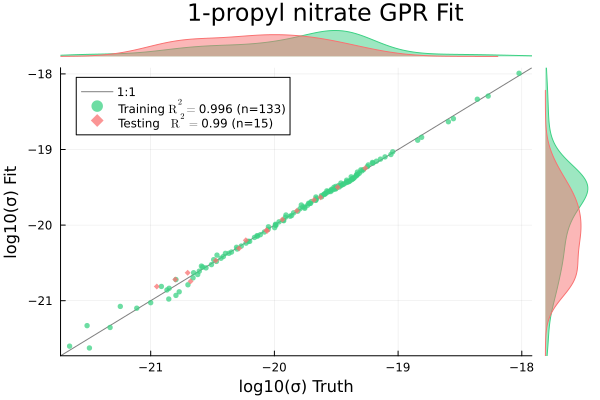

In [59]:
p = scatterresult(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    plot_title="$(nice_name) GPR Fit"
)


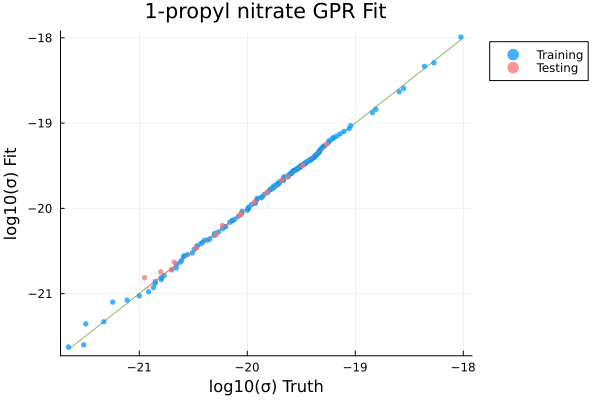

In [60]:
p = quantilequantile(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    title="$(nice_name) GPR Fit"
)


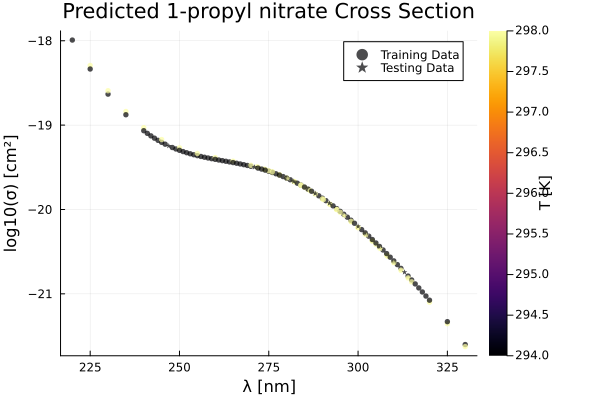

In [61]:
p1 = scatter(
    Xtrain.λ,
    y_pred_train,
    zcolor=Xtrain.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    label="Training Data",
)

scatter!(
    Xtest.λ,
    y_pred_test,
    zcolor=Xtest.T,
    ms=3, 
    msw=0,
    # markershape=:rect,
    markershape=:star5,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Predicted $(nice_name) Cross Section",
    label="Testing Data",
)


Finally, let's try prediction at the desired wavelength bins: 

220.0
330.0


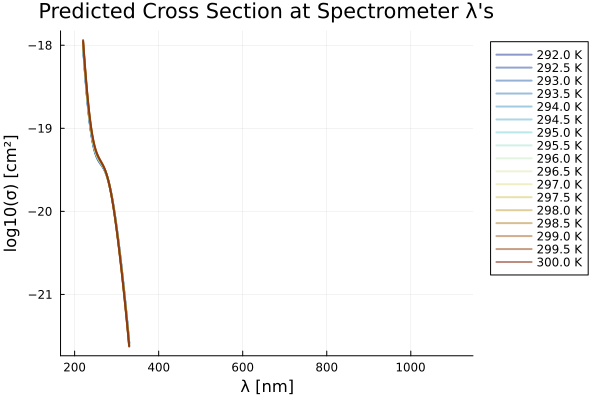

In [62]:
λ_min = maximum([min_data_λ, minimum(hr4000_df.λ)])
λ_max = minimum([max_data_λ, maximum(hr4000_df.λ)])

println(λ_min)
println(λ_max)

p = plot()

Ts = 292.0:0.5:300.0
# cs = cgrad(:thermal, Ts, categorical = true)
cs = cgrad(:roma, size(Ts,1), categorical = true, rev=true)
i = 1
for T ∈ Ts
    logσ = predict_logσ(T, hr4000_df, mach, (λ_min, λ_max))
    plot!(
        hr4000_df.λ, logσ,
        linewidth=2,
        alpha=0.5,
        color=cs[i],
        label="$(T) K",
        legend=:outertopright,
    )
    i+=1
end

xlabel!("λ [nm]")
ylabel!("log10(σ) [cm²]")
title!("Predicted Cross Section at Spectrometer λ's")

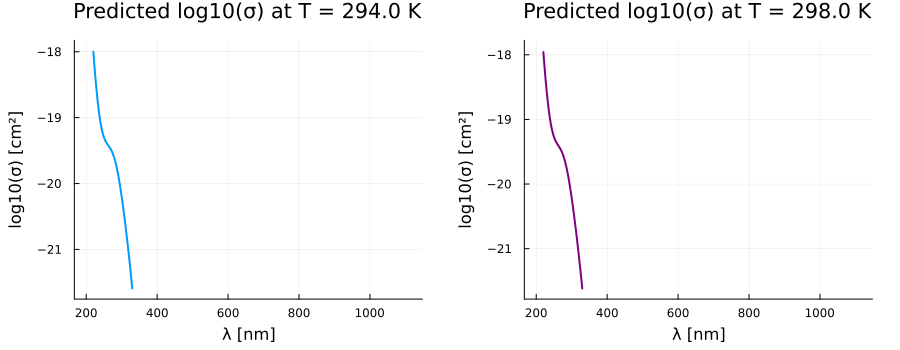

In [63]:
Tplot = 294.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

p1 = plot(
    hr4000_df.λ, logσ,
    ribbon= 2 .* Δlogσ,
    fillalpha=0.5,
    linewidth=2,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label="",
)

Tplot = 298.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

p2 = plot(
    hr4000_df.λ, logσ,
    ribbon= 2 .* Δlogσ,
    fillalpha=0.5,
    linewidth=2,
    color=:purple,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label=""
)

plot(p1, p2, layout=(1,2), margin=5Plots.mm, size=(900,350)) 

# Output for Photolysis Rate Determination

In [64]:
df_photolysis_σ = CSV.File("../photolysis_σ.csv") |> DataFrame 

describe(df_photolysis_σ)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,λ,667.499,194.249,672.636,1120.22,0,Float64
2,σ_1,5.26742e-19,0.0,2.82646e-22,1.17236e-17,0,Float64
3,σ_2,5.26742e-19,0.0,2.82646e-22,1.17236e-17,0,Float64
4,σ_3,2.15632e-20,0.0,0.0,7.82292e-19,0,Float64
5,σ_4,1.25113e-19,0.0,6.4171e-21,6.41009e-19,0,Float64
6,σ_5,6.58792e-19,0.0,1.71951e-28,1.5094e-17,0,Float64
7,σ_6,6.58792e-19,0.0,1.71951e-28,1.5094e-17,0,Float64
8,σ_7,8.4788e-20,0.0,0.0,2.33417e-18,0,Float64
9,σ_8,8.92125e-20,0.0,0.0,1.11355e-17,0,Float64


In [65]:
λ_min = minimum(df_sampled.λ)
λ_max = maximum(df_sampled.λ)

println(λ_min, "\t", minimum(df_photolysis_σ.λ))
println(λ_max, "\t", maximum(df_photolysis_σ.λ))

220.0	194.249
330.0	1120.216


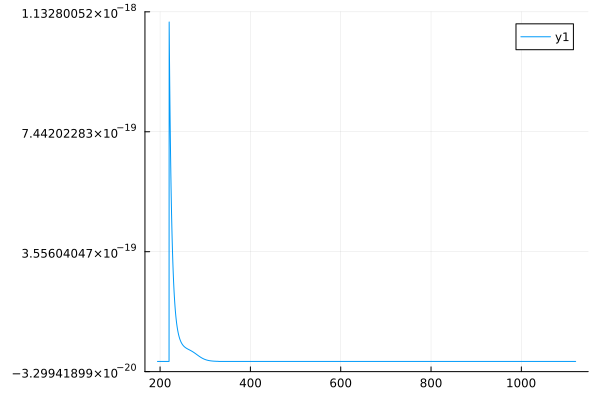

In [66]:
Tplot = 298.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

σ = 10 .^ logσ

replace!(σ, NaN => 0.0)

# set anything outside of λ range to 0 as well
σ[hr4000_df.λ .< λ_min .|| hr4000_df.λ .> λ_max] .= 0.0


plot(hr4000_df.λ, σ)

In [67]:
df_photolysis_σ.σ_53 = σ

describe(df_photolysis_σ)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,λ,667.499,194.249,672.636,1120.22,0,Float64
2,σ_1,5.26742e-19,0.0,2.82646e-22,1.17236e-17,0,Float64
3,σ_2,5.26742e-19,0.0,2.82646e-22,1.17236e-17,0,Float64
4,σ_3,2.15632e-20,0.0,0.0,7.82292e-19,0,Float64
5,σ_4,1.25113e-19,0.0,6.4171e-21,6.41009e-19,0,Float64
6,σ_5,6.58792e-19,0.0,1.71951e-28,1.5094e-17,0,Float64
7,σ_6,6.58792e-19,0.0,1.71951e-28,1.5094e-17,0,Float64
8,σ_7,8.4788e-20,0.0,0.0,2.33417e-18,0,Float64
9,σ_8,8.92125e-20,0.0,0.0,1.11355e-17,0,Float64


In [68]:
CSV.write("../photolysis_σ.csv", df_photolysis_σ)

"../photolysis_σ.csv"